In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot


def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders


hide_input()

In [110]:
model = nengo.Network(label="NEF summary")

intercepts, encoders = aligned(32)

with model:
    cos = nengo.Node(lambda t: np.cos(8 * t))

    direct = nengo.Ensemble(
        16,
        dimensions=2
    )

    A = nengo.Ensemble(
        32,
        dimensions=2,
        # intercepts=intercepts,
        max_rates=Uniform(80, 100),
        # encoders=encoders,
    )

    nengo.Connection(cos, direct[0])
    nengo.Connection(cos, direct[1])
    conn0 = nengo.Connection(direct[0], A[0], function=lambda x : x ** 2)
    A_spikes = nengo.Probe(A.neurons)
    A_PSC = nengo.Probe(A.neurons, synapse=0.01)
    Ap = nengo.Probe(A,synapse=0.01)
    D_spikes = nengo.Probe(direct.neurons)
    D_PSC = nengo.Probe(direct.neurons, synapse=0.01)
    Dp = nengo.Probe(direct,synapse=0.01)

/Users/beep/PycharmProjects/nengoPlayground/venv/lib/python3.8/site-packages/nengo/builder/optimizer.py:654: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

ValueError: x and y can be no greater than 2D, but have shapes (50, 50, 2) and (50, 50, 32)

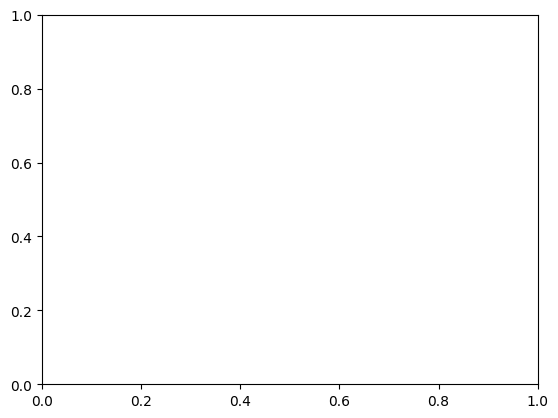

In [111]:
with nengo.Simulator(model) as sim:
    sim.run(1)
    plt.plot(*tuning_curves(A, sim))
    plt.ylabel("Firing rate (Hz)")
    plt.xlabel("Input scalar, x")
    plt.title("Tuning curves of ens A")
    plt.show()

    plt.plot(*tuning_curves(A, sim))
    plt.ylabel("Firing rate (Hz)")
    plt.xlabel("Input scalar, x")
    plt.title("Tuning curves of ens direct")
    plt.show()



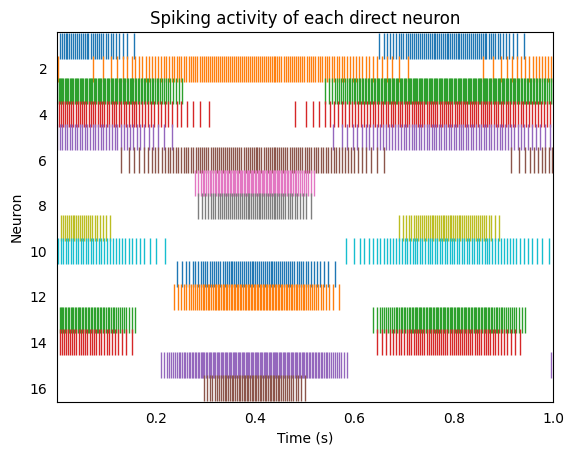

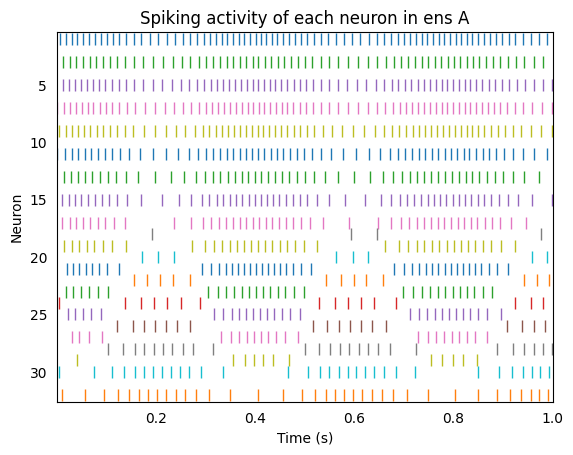

In [59]:
rasterplot(sim.trange(), sim.data[D_spikes])
plt.ylabel("Neuron")
plt.xlabel("Time (s)")
plt.title('Spiking activity of each direct neuron')
plt.show()

rasterplot(sim.trange(), sim.data[A_spikes])
plt.ylabel("Neuron")
plt.xlabel("Time (s)")
plt.title('Spiking activity of each neuron in ens A')
plt.show()

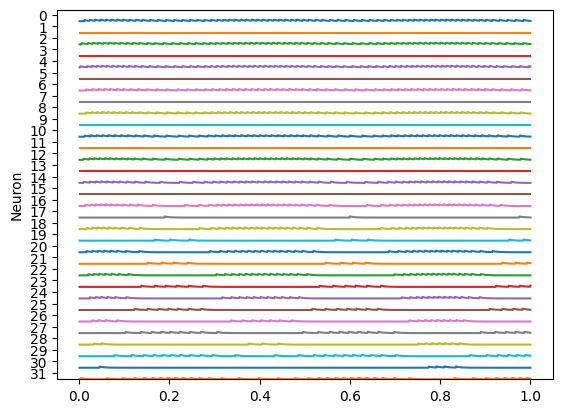

In [61]:
scale = 980
for i in range(A.n_neurons):
    plt.plot(sim.trange(), sim.data[A_PSC][:, i] - i * scale)
plt.ylim(scale * (-A.n_neurons + 1), scale)
plt.ylabel("Neuron")
plt.yticks(
    np.arange(scale / 1.8, (-A.n_neurons + 1) * scale, -scale), np.arange(A.n_neurons)
)
plt.show()

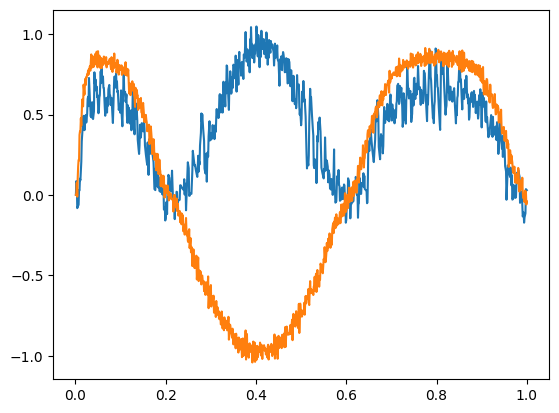

In [55]:
plt.plot(sim.trange(), sim.data[Ap])
plt.plot(sim.trange(), sim.data[Dp])

In [106]:
w = sim.data[conn0].weights[0]  # uh oh there'll be a new set of weights for a new dimension
n = 16
# first n of neurons ordered by descending weight
primary_components = np.argsort(w)[:n]
primary_components

array([ 6,  8, 12, 13, 15, 10,  5,  4, 14,  9,  1, 11,  2,  7,  0,  3])

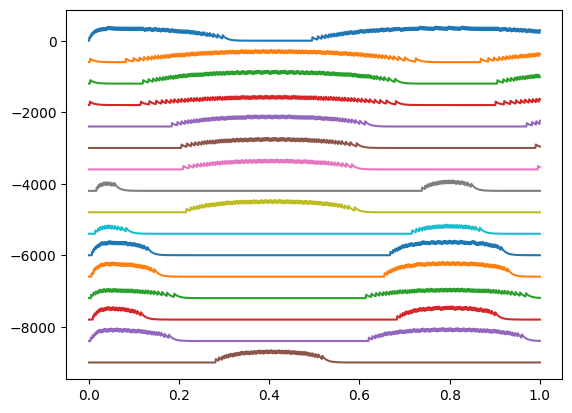

In [107]:
scale = 600
waterfall = 0
for neuron in primary_components:
    plt.plot(sim.trange(), sim.data[D_PSC][:, neuron] - waterfall * scale)
    waterfall += 1

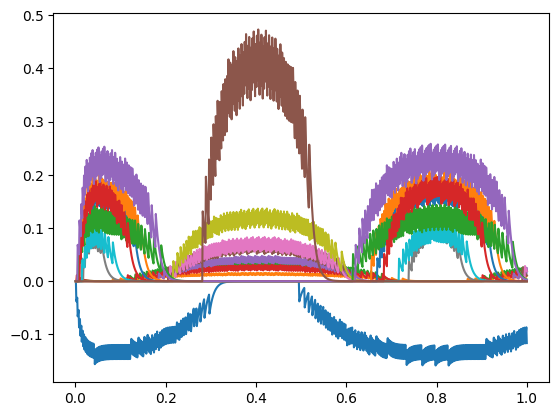

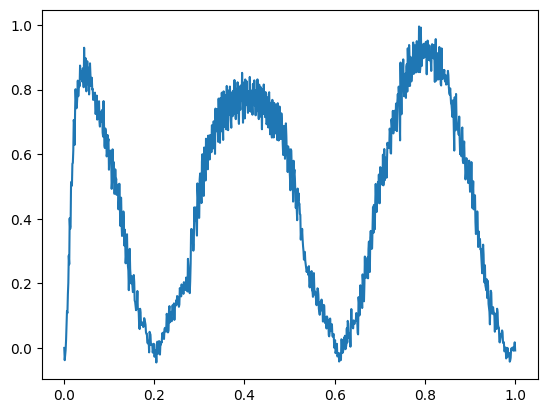

In [108]:
sum = np.zeros(sim.trange().shape)
for neuron in primary_components:
    contrib = sim.data[D_PSC][:, neuron] * w[neuron]
    sum += contrib
    plt.plot(sim.trange(), contrib)
plt.show()
plt.plot(sim.trange(), sum)

In [ ]:
plt.plot